### Cell 1 – Setup & Imports

In [1]:
!pip install -q transformers accelerate torch matplotlib pandas


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import pandas as pd, matplotlib.pyplot as plt, json, io, base64, textwrap
from IPython.display import Image, display


/home/harshal/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cell 2 – load Qwen llm

In [3]:
model_id = "Qwen/Qwen2.5-3B-Instruct"
tok = AutoTokenizer.from_pretrained(model_id)
mod = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
llm = pipeline("text-generation", model=mod, tokenizer=tok)

def ask_llm(prompt, max_new_tokens=250):
    out = llm(prompt, max_new_tokens=max_new_tokens, do_sample=False)
    return out[0]["generated_text"].split(prompt)[-1].strip()


Loading checkpoint shards: 100%|██████████████████| 2/2 [00:03<00:00,  1.89s/it]
Some parameters are on the meta device because they were offloaded to the disk and cpu.
Device set to use cpu


### Cell 3 – Shared Utils + Tool Executor

In [4]:
def run_python(code, local_vars=None):
    g = {} if local_vars is None else dict(local_vars)
    try:
        exec(code, {}, g)
        return {"ok": True, "globals": g}
    except Exception as e:
        return {"ok": False, "error": str(e)}

def b64_chart(x, y, title="Chart"):
    plt.figure()
    plt.plot(x, y, marker="o"); plt.title(title)
    buf = io.BytesIO(); plt.savefig(buf, format="png")
    return base64.b64encode(buf.getvalue()).decode()

def show_chart(b64): display(Image(data=base64.b64decode(b64)))


### Cell 4 – Planner Agent

In [5]:
# # =========================
# # Normalizer (SYSTEM v3)
# # =========================
# SYSTEM = 
# # =========================
# # Normalizer (USER_TMPL v3)
# # =========================
# USER_TMPL = """
    
def planner_agent(request, context):
    prompt = f"""
You are a planner AI.
If the request is ambiguous, ask ONE clarifying question first in JSON:
{{"need_clarification":true,"question":"..."}}
Otherwise, output JSON plan:
{{"need_clarification":false,"steps":[{{"agent":"Researcher","task":"..."}}]}}
User request: {request}
"""
    ans = ask_llm(prompt)
    try: plan = json.loads(ans)
    except: plan = {"need_clarification":False,
                    "steps":[{"agent":"Researcher","task":request},
                             {"agent":"Coder","task":"Plot trend"},
                             {"agent":"Analyst","task":"Interpret chart"},
                             {"agent":"Writer","task":"Summarize"}]}
    print("🧭 Plan:", plan)
    return plan


### Cell 5 – Agents (Roles + Prompts)

In [22]:
# updated
def coder_agent(task, context):
    """Aggregate last 3 quarters from transaction_date / transaction_amount and plot."""
    if context.get("data_df") is not None:
        df = context["data_df"].copy()

        # Detect columns
        date_col = next((c for c in df.columns if "date" in c.lower()), None)
        amt_col  = next((c for c in df.columns if "amount" in c.lower()), None)

        if date_col and amt_col:
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
            df = df.dropna(subset=[date_col, amt_col])

            # Quarterly aggregation (avoids deprecated 'Q' grouper usage)
            qsum = (
                df.resample("Q", on=date_col)[amt_col]
                  .sum()
                  .reset_index()
                  .sort_values(date_col)
            )

            # Keep last 3 quarters
            qsum = qsum.tail(3).reset_index(drop=True)

            # Build labels like 2025Q1, 2025Q2, ...
            x = qsum[date_col].dt.to_period("Q").astype(str).tolist()
            y = qsum[amt_col].tolist()

            img = b64_chart(x, y, "Quarterly Transaction Volume")
            context["chart"] = img
            context["quarterly_summary"] = qsum
            print("🧮 Coder aggregated last 3 quarters.")
            return img

        print("⚠️ Coder: Could not detect date or amount columns. Using mock data.")
        x, y = ["Q1","Q2","Q3"], [100, 150, 180]
        img = b64_chart(x, y, "Simulated Trend")
        context["chart"] = img
        return img

    # Fallback mock
    x, y = ["Q1","Q2","Q3"], [100, 150, 180]
    img = b64_chart(x, y, "Simulated Trend")
    context["chart"] = img
    print("🧮 Coder generated mock chart.")
    return img


def analyst_agent(task, context):
    """Explain quarterly movement using actual totals when available."""
    if "quarterly_summary" in context:
        qsum = context["quarterly_summary"].copy()
        # qsum has 3 rows, column 1 is the aggregated amount
        first = float(qsum.iloc[0, 1]) if qsum.shape[1] > 1 else 0.0
        middle = float(qsum.iloc[1, 1]) if qsum.shape[0] > 1 else 0.0
        last  = float(qsum.iloc[2, 1]) if qsum.shape[0] > 2 else 0.0
        growth_pct = ((last / first) - 1.0) * 100 if first > 0 else 0.0

        labels = qsum.iloc[:, 0].dt.to_period("Q").astype(str).tolist()
        desc = (
            f"Quarterly totals ({', '.join(labels)}): "
            f"{first:.2f}, {middle:.2f}, {last:.2f}. "
            f"Overall change: {growth_pct:.2f}% from first to last quarter."
        )
        context["analysis"] = desc
        print("🔍 Analyst (data-based):", desc)
        return desc

    # Fallback to text-only analysis
    notes = context.get("research_notes", "")
    prompt = f"You are an analyst. Interpret this information:\n{notes}\nBe concise."
    out = ask_llm(prompt)
    context["analysis"] = out
    print("🔍 Analyst (text-based):", out[:120])
    return out


### Cell 6 – Orchestrator

In [23]:
def orchestrator(request, data_path=None):
    ctx = {}
    if data_path:
        try: ctx["data_df"]=pd.read_csv(data_path) if data_path.endswith(".csv") else pd.read_json(data_path)
        except Exception as e: print("⚠️ Data load failed:", e)
    plan = planner_agent(request, ctx)
    if plan.get("need_clarification"):
        q=plan["question"]; print("❓ Clarification asked:", q)
        ans=input("Your answer: "); return orchestrator(ans, data_path)
    for s in plan["steps"]:
        a=s["agent"].lower()
        if a=="researcher": researcher_agent(s["task"], ctx)
        elif a=="coder": coder_agent(s["task"], ctx)
        elif a=="analyst": analyst_agent(s["task"], ctx)
        elif a=="writer": writer_agent(s["task"], ctx)
    return {"request":request,"summary":ctx.get("final_summary",""),
            "chart":ctx.get("chart"),"context":ctx}


### Cell 7 – Run with Optional CSV

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/tmp/ipykernel_13622/173107549.py:17: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df.resample("Q", on=date_col)[amt_col]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🧭 Plan: {'need_clarification': False, 'steps': [{'agent': 'Researcher', 'task': 'Summarize the last three quarters’ financial performance and create a chart.'}, {'agent': 'Coder', 'task': 'Plot trend'}, {'agent': 'Analyst', 'task': 'Interpret chart'}, {'agent': 'Writer', 'task': 'Summarize'}]}
📊 Researcher used uploaded data.
🧮 Coder aggregated last 3 quarters.
🔍 Analyst (data-based): Quarterly totals (2025Q2, 2025Q3, 2025Q4): 257916.68, 247988.14, 46608.06. Overall change: -81.93% from first to last quarter.
📝 Writer: The numeric summary indicates that the transaction amount has a mean of $509.55 with a standard deviation of $283.91 and
{
  "request": "Summarize the last three quarters\u2019 financial performance and create a chart.",
  "summary": "The numeric summary indicates that the transaction amount has a mean of $509.55 with a standard deviation of $283.91 and ranges from $10.21 to $998.56. Quarterly totals for 2025Q2, 2025Q3, and 2025Q4 are $257,916.68, $247,988.14, and $46,60

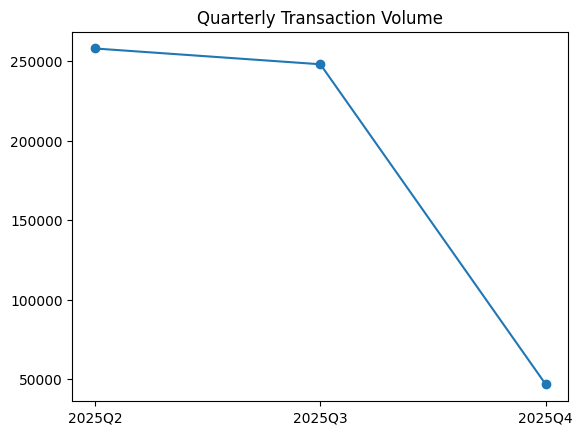

In [25]:
# Example 1: no CSV → simulated data
user_req = "Summarize the last three quarters’ financial performance and create a chart."
final = orchestrator(user_req, data_path = 'sales.csv')

print(json.dumps({k:v for k,v in final.items() if k!='context'}, indent=2)[:400], "...")


### Cell 8 – Visualize (if exists)


📊 Quarterly Trend Visualization:


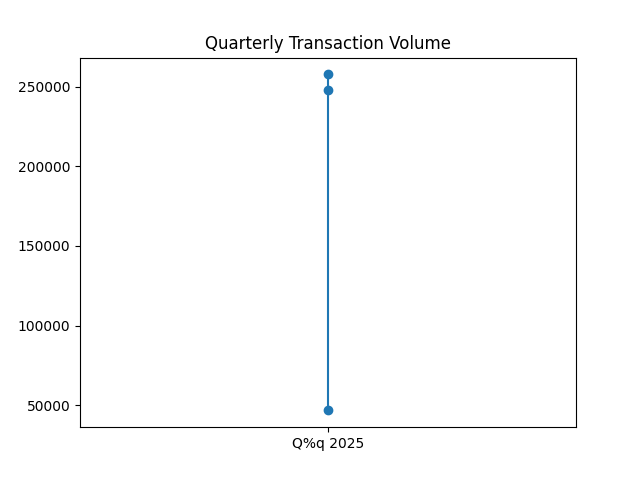

In [20]:
if final.get("chart"):
    print("\n📊 Quarterly Trend Visualization:")
    show_chart(final["chart"])


## csv rough

In [ ]:
import pandas as pd, numpy as np
from datetime import datetime, timedelta
import random, string

# config
n_users = 25
records = 2000
end_date = datetime.today()
start_date = end_date - timedelta(days=365)


def random_card():
    return ''.join(random.choices(string.digits, k=4)) + "XXXX" + ''.join(random.choices(string.digits, k=4))

# generate data debugg_1
data = []
for _ in range(records):
    user = f"U{random.randint(100,999)}"
    card = random_card()
    date = start_date + timedelta(days=random.randint(0,365))
    amt = round(random.uniform(10, 1000), 2)
    data.append([user, card, amt, date.strftime("%Y-%m-%d")])

df = pd.DataFrame(data, columns=["customer_id", "card_no", "transaction_amount", "transaction_date"])
df.to_csv("sales.csv", index=False)
print("✅ Generated sales.csv with", len(df), "rows")
df.head(10)
